# A Diversity Analysis of Participation in Outdoor Recreation in Washington

### Final Project for HCDS 512, Autumn 2018

The purpose of this notebook is to complete a statistical analysis and visualization of the racial and gender diversity of participants in certain outdoor recreational activities in Washington State. This work was originally completed for the University of Washington's DATA 512 course on Human Centered Data Science in Autumn 2018. 

The notebook is divided into the following sections:

 - Introduction
 - Background
 - Data
     - Data Source
     - Data Acquisition
     - Data Processing
 - Data Visualization
 - Statistical Analysis
 - Discussion
 - Conclusion
 - References

All sections are thoroughly documented so as to support reproducibility of this analysis.

## Introduction

In [205]:
# import necessary packages and notebook setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sodapy import Socrata
import statsmodels.stats.proportion as ssp

## Background

## Data

### Data Source

### Data Acquisition

code from this link: https://dev.socrata.com/foundry/data.wa.gov/amq9-iaai

In [23]:
# Define endpoints for each of the 7 parts of the dataset
endpoints = ['amq9-iaai', 'ek6m-rgb7', '8zc8-9ad4', 'v2c2-rkrp', 'hzyw-na2k', 'uwas-gd9z', 'q62a-ce6s']

# Define app token for API requests
app_token = 'OnW02vywUSKEfNP2DEYO7OMM5'

#Create dictionary to save dataframes
parts = {}

# Make API call for each endpoint and save file
for endpoint in endpoints:
    file_name = 'data_raw/scorp_' + endpoint + '.csv'
    client = Socrata("data.wa.gov", app_token)
    results = client.get(endpoint, limit=3200)
    results_df = pd.DataFrame.from_records(results)
    results_df.to_csv(file_name)
    parts[endpoint] = results_df

### Data Processing

In [39]:
#Merge all dataframes from the data dictionary
keys = list(parts.keys())
combined_data = parts[keys[0]]

for i in range(1, len(keys)):
    combined_data = combined_data.merge(parts[keys[i]], how = 'inner', on = ['idnumber'])
    
# Check shape of resulting dataframe
combined_data.shape

In [41]:
# Check first few rows of resulting dataframe
combined_data.head()

,act1,act101,act102,act103,act104,act105,act106,act107,act108,act109,...,tab245a,tab285a,tenn2x,voll3x,walk8x,wghts2x,wski2x,wsrf2x,xski2x,xski6x
0,1111000000100000,Not checked,Not checked,Checked,Checked,Checked,Checked,Not checked,Not checked,Not checked,...,No,No,14.00,0.00,0.00,60.00,0.00,0.00,0.00,0.00
1,10,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,365.00,0.00,0.00,0.00,0.00,0.00
2,1100000000000000,Not checked,Not checked,Checked,Checked,Not checked,Not checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,100.00,50.00,0.00,0.00,0.00,0.00
3,100001101111001000,Checked,Not checked,Not checked,Not checked,Not checked,Checked,Checked,Not checked,Checked,...,No,Yes,0.00,15.00,40.00,0.00,12.00,20.00,5.00,0.00
4,1000000000000,Not checked,Not checked,Not checked,Not checked,Not checked,Checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00


In [52]:
# Change "checked/not checked" and "yes/no" to 0/1
combined_data = combined_data.replace({'Yes': 1, 'No': 0, 'Not checked': 0, 'Checked': 1})
combined_data.head()

,act1,act101,act102,act103,act104,act105,act106,act107,act108,act109,...,tab245a,tab285a,tenn2x,voll3x,walk8x,wghts2x,wski2x,wsrf2x,xski2x,xski6x
0,1111000000100000,0,0,1,1,1,1,0,0,0,...,0,0,14.00,0.00,0.00,60.00,0.00,0.00,0.00,0.00
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0.00,0.00,365.00,0.00,0.00,0.00,0.00,0.00
2,1100000000000000,0,0,1,1,0,0,0,0,0,...,0,0,0.00,0.00,100.00,50.00,0.00,0.00,0.00,0.00
3,100001101111001000,1,0,0,0,0,1,1,0,1,...,0,1,0.00,15.00,40.00,0.00,12.00,20.00,5.00,0.00
4,1000000000000,0,0,0,0,0,1,0,0,0,...,0,0,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00


In [419]:
# Drop participants with no gender and check shape
combined_data.gender.unique()
gender_dataset_full = combined_data[combined_data.gender != "Don't know"]
gender_dataset_full.shape

(3112, 1575)

In [94]:
# Drop participants with no race/ethnicity information "Don't know" and "Refused"
race_dataset_full = combined_data[combined_data.race09 != 1]
race_dataset_full = race_dataset_full[race_dataset_full.race08 != 1]
race_dataset_full.shape

(2910, 1575)

https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

In [80]:
# Create one race column - define function to map columns to races
def label_race (row):
   if row['race01'] == 1 :
      return 'White'
   if row['race01'] + row['race02'] + row['race03'] + row['race04'] + row['race05'] + row['race06'] + row['race07'] > 1 :
      return 'Two Or More'
   if row['race02'] == 1 :
      return 'Black'
   if row['race03'] == 1:
      return 'Hispanic/Latino'
   if row['race04']  == 1:
      return 'Asian'
   if row['race05'] == 1:
      return 'Haw/Pac Isl.'
   if row['race06'] == 1:
      return 'American Indian/Alaska Native'
   return 'Other'

In [95]:
race_dataset_full['race_label'] = race_dataset_full.apply(label_race, axis=1)

In [ ]:
def any_backcountry(row):
    if np.nansum(row) > 0:
        return 1
    return 0

In [417]:
# Subset data to get only needed fields
race_small = race_dataset_full[['idnumber', 
                                'snoact04', 
                                'snoact01', 
                                'snoact05', 
                                'climb101', 
                                'climb102',
                                'camp103', 
                                'hik203', 
                                'race_label']]

gender_small = gender_dataset_full[['idnumber', 
                                'snoact04', 
                                'snoact01', 
                                'snoact05', 
                                'climb101', 
                                'climb102',
                                'camp103', 
                                'hik203', 
                                'gender']]

In [418]:
# Get any backcountry designation
backcountry_fields = ['snoact04', 
                      'snoact01', 
                      'snoact05', 
                      'climb101', 
                      'climb102', 
                      'camp103', 
                      'hik203']

race_small_fields = race_small[backcountry_fields]
race_small.loc['any_backcountry'] = race_small_fields.apply(any_backcountry, axis=1)
gender_small_fields = gender_small[backcountry_fields]
gender_small.loc['any_backcountry'] = gender_small_fields.apply(any_backcountry, axis=1)

C:\Users\kentd\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kentd\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [243]:
# Save data sets to clean data folder
race_small.to_csv('data_clean/race_data_clean.csv')
gender_small.to_csv('data_clean/gender_data_clean.csv')

In [ ]:
gender_nobs = gender_small.groupby(['gender'], sort=False).size()
gender_counts = gender_small.groupby(['gender'], sort=False)['any_backcountry'].sum()
race_nobs = race_small.groupby(['race_label'], sort=False).size()
race_counts = race_small.groupby(['race_label'], sort=False)['any_backcountry'].sum()
# Proportion who participate in backcountry
gender_props = gender_counts/gender_nobs
race_props = race_counts/race_nobs
gender_counts_all = gender_small.groupby(['gender'], sort=False).sum()
gender_props_all = gender_counts_all.div(gender_nobs, axis=0)
race_counts_all = race_small.groupby(['race_label'], sort=False).sum()
race_props_all = race_counts_all.div(race_nobs, axis=0)

## Data Visualization

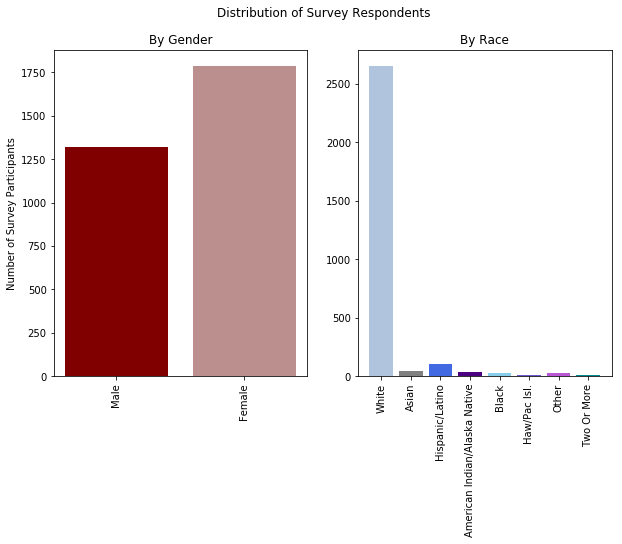

In [420]:
# Sampling distribution
fig = plt.figure(figsize=(10,6))
fig.suptitle('Distribution of Survey Respondents')
ax1 = fig.add_subplot(121)
ind = np.arange(2)
colors = ['maroon', 'rosybrown']
gender = ax1.bar(ind, gender_nobs, color=colors)
plt.xticks(rotation=90)
ax1.set_ylabel('Number of Survey Participants')
ax1.set_title('By Gender')
ax1.set_xticks(ind)
ax1.set_xticklabels(gender_nobs.index);

ax2 = fig.add_subplot(122)
ind2 = np.arange(8)
colors2 = ['lightsteelblue', 'grey', 'royalblue', 'indigo', 'skyblue', 'slateblue', 'mediumorchid', 'darkcyan']
race = ax2.bar(ind2, race_nobs, color=colors2)
ax2.set_title('By Race')
plt.xticks(rotation=90)
ax2.set_xticks(ind2)
ax2.set_xticklabels(race_nobs.index)

plt.savefig('results/respondent_distribution.png')
plt.show();

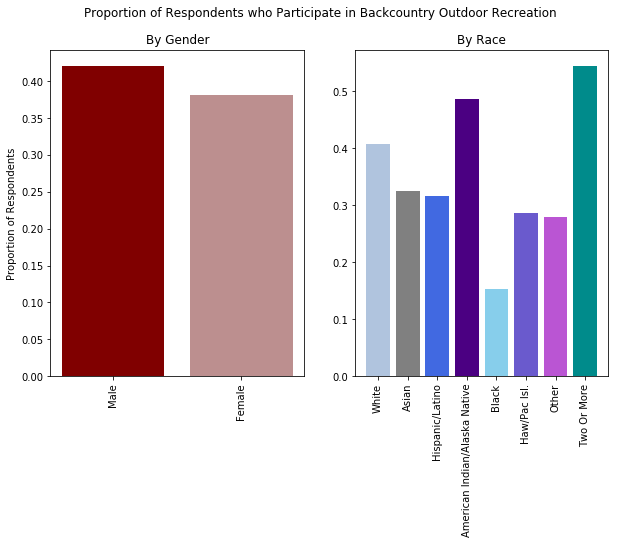

In [421]:
fig2 = plt.figure(figsize=(10,6))
fig2.suptitle('Proportion of Respondents who Participate in Backcountry Outdoor Recreation')
ax3 = fig2.add_subplot(121)
gender2 = ax3.bar(ind, gender_props, color=colors)
ax3.set_title('By Gender')
plt.xticks(rotation=90)
ax3.set_ylabel('Proportion of Respondents')
ax3.set_xticks(ind)
ax3.set_xticklabels(gender_props.index);

ax4 = fig2.add_subplot(122)
race2 = ax4.bar(ind2, race_props, color=colors2)
ax4.set_title('By Race')
plt.xticks(rotation=90)
ax4.set_xticks(ind2)
ax4.set_xticklabels(race_props.index)
plt.savefig('results/participation_in_backcountry_general.png')
plt.show;

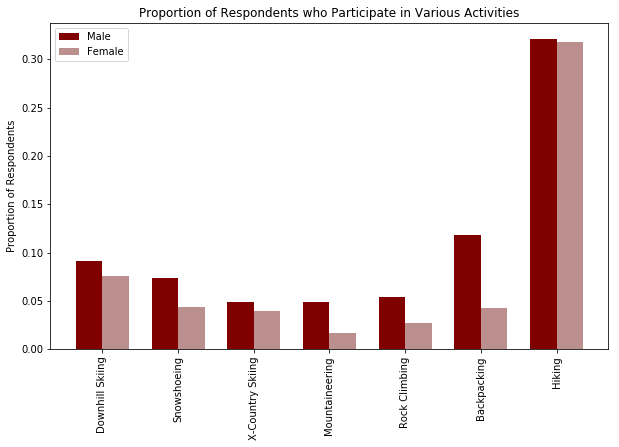

In [423]:
ind3 = np.arange(7)
width3 = 0.35
fig3 = plt.figure(figsize=(10,6))
backcountry_ticks = ['Downhill Skiing', 
                     'Snowshoeing', 
                     'X-Country Skiing', 
                     'Mountaineering', 
                     'Rock Climbing', 
                     'Backpacking', 
                     'Hiking']
ax5 = fig3.add_subplot(111)
male = ax5.bar(ind3, gender_props_all.iloc[0, 0:7], width3, color=colors[0])
female = ax5.bar(ind3 + width3, gender_props_all.iloc[1, 0:7], width3, color=colors[1])
plt.xticks(rotation=90)
ax5.set_title('Proportion of Respondents who Participate in Various Activities')
ax5.set_ylabel('Proportion of Respondents')
ax5.set_xticks(ind3 + width3 / 2)
ax5.set_xticklabels(backcountry_ticks)
ax5.legend(gender_props.index)

plt.savefig('results/gender_participation_in_backcountry_specific.png')
plt.show;

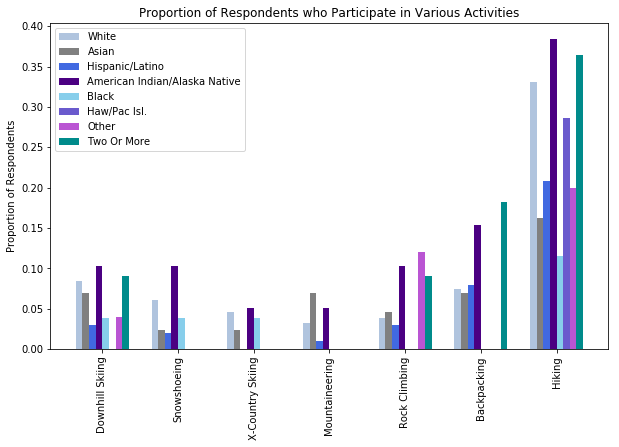

In [424]:
fig4 = plt.figure(figsize=(10,6))
ax6 = fig4.add_subplot(111)
ind4 = np.arange(7)
width4 = 0.7

for i in range(8):
    ax6.bar(ind4 - width/2. + i/8*width4, race_props_all.iloc[i, 0:7], 
            width=width4/8, align="edge", color=colors2[i])   

plt.xticks(rotation=90)
ax6.set_title('Proportion of Respondents who Participate in Various Activities')
ax6.set_ylabel('Proportion of Respondents')
ax6.set_xticks(ind4 + width4/7)
ax6.set_xticklabels(backcountry_ticks)
ax6.legend(race_props_all.index)

plt.savefig('results/race_participation_in_backcountry_specific.png')
plt.show;

## Statistical Analysis

downhill skiing (snoact04), snowshoeing (snoact01), x-country skiing (snoact05), mountaineering (climb101), rock climbing(climb102), backpacking (camp103), hiking (hik203)

### Gender

In [311]:
z_gender, p_gender = ssp.proportions_ztest(gender_counts, gender_nobs)
print("Results of 2-sided hypothesis test for gender:", round(p_gender, 4))

Results of 2-sided hypothesis test for gender: 0.0251


In [247]:
# Calculate confidence interval
gender_pooled = sum(gender_counts)/sum(gender_nobs)
gender_se_prop = np.sqrt(gender_pooled*(1-gender_pooled)*sum(1/gender_nobs))

gender_lower = (gender_props[0] - gender_props[1]) - 1.96*gender_se_prop
gender_upper = (gender_props[0] - gender_props[1]) + 1.96*gender_se_prop

print("Confidence interval for difference in proportions:", round(gender_lower,3), "-", round(gender_upper,3))

Confidence interval for difference in proportions: 0.005 - 0.075


### Race

In [249]:
for i in range(1, 8):   
    obs = np.array([[race_counts[0], race_nobs[0]-race_counts[0]], [race_counts[i], race_nobs[i]-race_counts[i]]])
    chi2, p, dof, expected = stats.chi2_contingency(obs, correction = True)
    print("Results of hypothesis test for difference between white and", race_counts.index[i], ":", round(p, 3))

Results of hypothesis test for difference between white and Asian : 0.353
Results of hypothesis test for difference between white and Hispanic/Latino : 0.086
Results of hypothesis test for difference between white and American Indian/Alaska Native : 0.4
Results of hypothesis test for difference between white and Black : 0.015
Results of hypothesis test for difference between white and Haw/Pac Isl. : 0.788
Results of hypothesis test for difference between white and Other : 0.277
Results of hypothesis test for difference between white and Two Or More : 0.534


In [ ]:
# Calculate confidence interval for difference in proportion between 
# people who identified as white and those who identified as black
pooled = sum(race_counts)/sum(race_nobs)
se_prop = np.sqrt(pooled*(1-pooled)*sum(1/race_nobs))

lower = (props[0] - props[1]) - 1.96*se_prop
upper = (props[0] - props[1]) + 1.96*se_prop

print("Confidence interval for difference in proportions:", round(lower,3), "-", round(upper,3))

## Discussion

## Conclusion

## References